DONE
Step 1: Preprocess the data - use the same function across the board
Clearing out the capitalization
Clearing out em dashes, symbols
Clearing out names

TO DO
Step 2: Implementing the features
- Goal: Train a logistic regression on 2 feature representations

Step 3: Implementing the regression based on that data

# Part 1: Imports and Cleaning Text

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import numpy as np
from sklearn.linear_model import LogisticRegression


/Users/kate/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in data
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')

In [3]:
# Helper function for cleaning text
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean

In [4]:
# use the clean_html function to clean the training data
train['snip'] = train['snip'].apply(clean_html)
val['snip'] = val['snip'].apply(clean_html)

print(train)
print(val)

                                                    snip   channel
0      first of all, it feels like covid again but in...  FOXNEWSW
1      to be a software drivenrganization where softw...     CSPAN
2      you discuss the power of ai to revolutionize t...    CSPAN2
3      ai bots like chatgpt and google's bard gained ...   BBCNEWS
4      . >> i could sleep ten hours ai night if i was...  FOXNEWSW
...                                                  ...       ...
19868  cardiovascular science, but they're also pione...  FOXNEWSW
19869  i of ai in different fields. have of ai in dif...   BBCNEWS
19870  weighing down on the major averages, both tech...      KTVU
19871  i also think crypto ai that legislation be fro...    CSPAN2
19872  as we have worked to monitor the adoption iden...    CSPAN2

[19873 rows x 2 columns]
                                                   snip    channel
0     . ♪ >> there's a kyu cho right have things tha...  BLOOMBERG
1     he says the ai tool helped cre

In [5]:
# evaluation metric equation
def eval(y_pred, y_true):
    correct = (y_pred == y_true)   # Boolean array: True if correct, False if wrong
    accuracy = correct.sum() / len(y_true)  # Correct / Total
    return accuracy

In [6]:
# Initialize and fit TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(train['snip'])

# Calculate word complexity per snip
word_complexity = X_tfidf.sum(axis=1) / (X_tfidf != 0).sum(axis=1)
word_complexity = np.array(word_complexity).flatten()

# Add it to the train dataframe
train['word_complexity'] = word_complexity

print(train)

                                                    snip   channel  \
0      first of all, it feels like covid again but in...  FOXNEWSW   
1      to be a software drivenrganization where softw...     CSPAN   
2      you discuss the power of ai to revolutionize t...    CSPAN2   
3      ai bots like chatgpt and google's bard gained ...   BBCNEWS   
4      . >> i could sleep ten hours ai night if i was...  FOXNEWSW   
...                                                  ...       ...   
19868  cardiovascular science, but they're also pione...  FOXNEWSW   
19869  i of ai in different fields. have of ai in dif...   BBCNEWS   
19870  weighing down on the major averages, both tech...      KTVU   
19871  i also think crypto ai that legislation be fro...    CSPAN2   
19872  as we have worked to monitor the adoption iden...    CSPAN2   

       word_complexity  
0             0.057407  
1             0.079768  
2             0.076151  
3             0.077301  
4             0.075782  
...      

In [7]:
# Transform validation snips using the same TF-IDF vectorizer
x_val_tfidf = vectorizer.transform(val['snip'])

# Compute complexity
val_word_complexity = x_val_tfidf.sum(axis=1) / (x_val_tfidf != 0).sum(axis=1)
val_word_complexity = np.array(val_word_complexity).flatten()

# Add to val DataFrame
val['word_complexity'] = val_word_complexity

print(val)

                                                   snip    channel  \
0     . ♪ >> there's a kyu cho right have things tha...  BLOOMBERG   
1     he says the ai tool helped create a new fronti...       KPIX   
2     . >> the all new godaddy arrow put your busine...       CNNW   
3     in some cases they are powered by generative a...      CSPAN   
4     this was a ivotal it comes to ai. this was a p...    BBCNEWS   
...                                                 ...        ...   
3034  however, the ai trade is only one part of the ...       CNBC   
3035  oz but also was highlighted as a product by cr...     CSPAN2   
3036  the all new godaddy airo helps you get your bu...       CNBC   
3037  we are going to be way ahead on ai. we have to...       CNBC   
3038  his fourth management role after spells at der...    BBCNEWS   

      word_complexity  
0            0.088216  
1            0.081808  
2            0.074722  
3            0.082919  
4            0.083567  
...            

In [8]:
# X = features, y = labels
x_train = train[['word_complexity']]  # Needs to be 2D
y_train = train['channel']

x_val = val[['word_complexity']]
y_val = val['channel']

In [9]:
# Train
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# Predict
val_preds = model.predict(x_val)
print(val_preds)

# Evaluate
val_accuracy = eval(val_preds, y_val)
print(val_accuracy)

['CNNW' 'CNNW' 'CNNW' ... 'CNNW' 'CNNW' 'CNNW']
0.07535373478117802


now do the min/max training to create new average values of scores

scaled = current - min/ max-min

In [10]:
min = 1
max = 0

complexity = train['word_complexity']
print(complexity)

for i in range(len(complexity)):
    if complexity[i] <= min:
        min = complexity[i]
    if complexity[i] >= max:
        max = complexity[i]
    else:
        min = min
        max = max

print(min,max)

0        0.057407
1        0.079768
2        0.076151
3        0.077301
4        0.075782
           ...   
19868    0.080295
19869    0.093252
19870    0.080397
19871    0.079097
19872    0.080723
Name: word_complexity, Length: 19873, dtype: float64
0.035929255415410526 0.6822632439493239


In [11]:
# complexity is 2D
def scale(complexity):
    x_train = (train[['word_complexity']] - min )/ (max-min)
    return x_train

In [12]:
min_complexity = train["word_complexity"].min()
max_complexity = train["word_complexity"].max()
train["word_complexity_scaled"] = (train["word_complexity"] - min_complexity) / (max_complexity - min_complexity)
val["word_complexity_scaled"] = (val["word_complexity"] - min_complexity) / (max_complexity - min_complexity)

# X = features, y = labels
x_train = train[['word_complexity_scaled']]
y_train = train['channel']

x_val = val[['word_complexity_scaled']]
y_val = val['channel']

In [13]:
# Train
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# Predict
val_preds = model.predict(x_val)
print(val_preds)

# Evaluate
val_accuracy = eval(val_preds, y_val)
print(val_accuracy)

['CNNW' 'CNNW' 'CNNW' ... 'CNNW' 'CNNW' 'CNNW']
0.07666995722277065


In [14]:
# create list of all of the channels
channels = []

for i in range(len(train)):
    if train['channel'][i] not in channels:
        channels.append(train['channel'][i])
    else:
        channels = channels

# 

print(channels)


['FOXNEWSW', 'CSPAN', 'CSPAN2', 'BBCNEWS', 'GBN', 'KPIX', 'KGO', 'KNTV', '1TV', 'KRON', 'CSPAN3', 'SFGTV', 'RUSSIA24', 'KSTS', 'BLOOMBERG', 'MSNBCW', 'PRESSTV', 'KTVU', 'CNNW', 'FBC', 'CNBC', 'RUSSIA1', 'KDTV', 'DW', 'KQED', 'NTV', 'BELARUSTV', 'ALJAZ', 'RT', 'LINKTV', 'COM']


In [15]:
train_corpus = list(train['snip'].values)
val_corpus = list(val['snip'].values)
nlp_sentiment = pipeline("sentiment-analysis")
train["Sentiment"] = nlp_sentiment(train_corpus)
val["Sentiment"] = nlp_sentiment(val_corpus)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [16]:
train['Sentiment_Label'] = [x.get('label') for x in train['Sentiment']]
train['Sentiment_Score'] = [x.get('score') for x in train['Sentiment']]
val['Sentiment_Label'] = [x.get('label') for x in val['Sentiment']]
val['Sentiment_Score'] = [x.get('score') for x in val['Sentiment']]

train.head()

,snip,channel,word_complexity,word_complexity_scaled,Sentiment,Sentiment_Label,Sentiment_Score
0,"first of all, it feels like covid again but in...",FOXNEWSW,0.057407,0.033231,"{'label': 'NEGATIVE', 'score': 0.9903525710105...",NEGATIVE,0.990353
1,to be a software drivenrganization where softw...,CSPAN,0.079768,0.067826,"{'label': 'POSITIVE', 'score': 0.9933253526687...",POSITIVE,0.993325
2,you discuss the power of ai to revolutionize t...,CSPAN2,0.076151,0.062230,"{'label': 'NEGATIVE', 'score': 0.9971946477890...",NEGATIVE,0.997195
3,ai bots like chatgpt and google's bard gained ...,BBCNEWS,0.077301,0.064009,"{'label': 'POSITIVE', 'score': 0.9900817275047...",POSITIVE,0.990082
4,. >> i could sleep ten hours ai night if i was...,FOXNEWSW,0.075782,0.061660,"{'label': 'NEGATIVE', 'score': 0.8428422808647...",NEGATIVE,0.842842


In [17]:
train["Sentiment_Score"] = np.where(
    train["Sentiment_Label"] == "NEGATIVE", -(train["Sentiment_Score"]), train["Sentiment_Score"]
)

val["Sentiment_Score"] = np.where(
    val["Sentiment_Label"] == "NEGATIVE", -(val["Sentiment_Score"]), val["Sentiment_Score"]
)

train.head()

,snip,channel,word_complexity,word_complexity_scaled,Sentiment,Sentiment_Label,Sentiment_Score
0,"first of all, it feels like covid again but in...",FOXNEWSW,0.057407,0.033231,"{'label': 'NEGATIVE', 'score': 0.9903525710105...",NEGATIVE,-0.990353
1,to be a software drivenrganization where softw...,CSPAN,0.079768,0.067826,"{'label': 'POSITIVE', 'score': 0.9933253526687...",POSITIVE,0.993325
2,you discuss the power of ai to revolutionize t...,CSPAN2,0.076151,0.062230,"{'label': 'NEGATIVE', 'score': 0.9971946477890...",NEGATIVE,-0.997195
3,ai bots like chatgpt and google's bard gained ...,BBCNEWS,0.077301,0.064009,"{'label': 'POSITIVE', 'score': 0.9900817275047...",POSITIVE,0.990082
4,. >> i could sleep ten hours ai night if i was...,FOXNEWSW,0.075782,0.061660,"{'label': 'NEGATIVE', 'score': 0.8428422808647...",NEGATIVE,-0.842842


In [18]:
min_sentiment = train["Sentiment_Score"].min()
max_sentiment = train["Sentiment_Score"].max()

train["Sentiment_scaled"] = (train["Sentiment_Score"] - min_sentiment) / (max_sentiment - min_sentiment)
val["Sentiment_scaled"] = (val["Sentiment_Score"] - min_sentiment) / (max_sentiment - min_sentiment)
train.head()


,snip,channel,word_complexity,word_complexity_scaled,Sentiment,Sentiment_Label,Sentiment_Score,Sentiment_scaled
0,"first of all, it feels like covid again but in...",FOXNEWSW,0.057407,0.033231,"{'label': 'NEGATIVE', 'score': 0.9903525710105...",NEGATIVE,-0.990353,0.004713
1,to be a software drivenrganization where softw...,CSPAN,0.079768,0.067826,"{'label': 'POSITIVE', 'score': 0.9933253526687...",POSITIVE,0.993325,0.996727
2,you discuss the power of ai to revolutionize t...,CSPAN2,0.076151,0.062230,"{'label': 'NEGATIVE', 'score': 0.9971946477890...",NEGATIVE,-0.997195,0.001292
3,ai bots like chatgpt and google's bard gained ...,BBCNEWS,0.077301,0.064009,"{'label': 'POSITIVE', 'score': 0.9900817275047...",POSITIVE,0.990082,0.995105
4,. >> i could sleep ten hours ai night if i was...,FOXNEWSW,0.075782,0.061660,"{'label': 'NEGATIVE', 'score': 0.8428422808647...",NEGATIVE,-0.842842,0.078481


In [19]:
x_train = train[['word_complexity_scaled', 'Sentiment_scaled']]  # Needs to be 2D
x_val = val[['word_complexity_scaled', 'Sentiment_scaled']]
model = LogisticRegression(max_iter=1000)

model.fit(x_train, y_train)

# Predict
val_preds = model.predict(x_val)
print(val_preds)

# Evaluate
val_accuracy = eval(val_preds, y_val)
print(val_accuracy)

['CNNW' 'CNNW' 'CNNW' ... 'CNNW' 'CNNW' 'CNNW']
0.07634090161237249


In [20]:
print(len(train["channel"].value_counts()))
print(train["channel"].value_counts())

31
channel
CNNW         2725
FBC          1608
BBCNEWS      1576
BLOOMBERG    1441
CNBC         1319
MSNBCW       1141
FOXNEWSW     1106
CSPAN         913
CSPAN2        904
KNTV          842
KTVU          766
KGO           763
KRON          760
GBN           717
CSPAN3        664
KPIX          400
SFGTV         360
DW            253
ALJAZ         230
NTV           209
KDTV          176
1TV           158
KSTS          142
RUSSIA24      122
PRESSTV       115
KQED          113
BELARUSTV     109
RUSSIA1       108
RT             50
LINKTV         43
COM            40
Name: count, dtype: int64


In [ ]:
from torch import nn
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


In [22]:
encoder = LabelEncoder()
encoder.fit(train['channel'])
training_labels = torch.tensor(encoder.transform(train['channel']))
val_labels = torch.tensor(encoder.transform(val['channel']))

class_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(class_mapping)

{'1TV': 0, 'ALJAZ': 1, 'BBCNEWS': 2, 'BELARUSTV': 3, 'BLOOMBERG': 4, 'CNBC': 5, 'CNNW': 6, 'COM': 7, 'CSPAN': 8, 'CSPAN2': 9, 'CSPAN3': 10, 'DW': 11, 'FBC': 12, 'FOXNEWSW': 13, 'GBN': 14, 'KDTV': 15, 'KGO': 16, 'KNTV': 17, 'KPIX': 18, 'KQED': 19, 'KRON': 20, 'KSTS': 21, 'KTVU': 22, 'LINKTV': 23, 'MSNBCW': 24, 'NTV': 25, 'PRESSTV': 26, 'RT': 27, 'RUSSIA1': 28, 'RUSSIA24': 29, 'SFGTV': 30}


In [23]:
training_data = torch.tensor(train[['word_complexity_scaled', 'Sentiment_scaled']].values)
val_data = torch.tensor(val[['word_complexity_scaled', 'Sentiment_scaled']].values)
train_tensor = torch.utils.data.TensorDataset(training_data, training_labels)
val_tensor = torch.utils.data.TensorDataset(val_data, val_labels)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_tensor, batch_size=batch_size)
val_dataloader = DataLoader(val_tensor, batch_size=batch_size)

for X, y in val_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 2])
Shape of y: torch.Size([64]) torch.int64


In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

X = torch.rand(1, 2)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=31, bias=True)
  )
)
Predicted class: tensor([1])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train_fxn(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.float()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 3.419219  [   64/19873]
loss: 3.365708  [ 6464/19873]
loss: 3.298280  [12864/19873]
loss: 3.198684  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.282800 

Epoch 2
-------------------------------
loss: 3.359068  [   64/19873]
loss: 3.266758  [ 6464/19873]
loss: 3.176203  [12864/19873]
loss: 3.025360  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.195135 

Epoch 3
-------------------------------
loss: 3.332412  [   64/19873]
loss: 3.202513  [ 6464/19873]
loss: 3.096110  [12864/19873]
loss: 2.906666  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.138198 

Epoch 4
-------------------------------
loss: 3.321265  [   64/19873]
loss: 3.162539  [ 6464/19873]
loss: 3.049148  [12864/19873]
loss: 2.831460  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.097648 

Epoch 5
-------------------------------
loss: 3.309592  [   64/19873]
loss: 3.132886  [ 6464/19873]
loss: 3.021311  [12864/19873]
loss: 2.783782  [19264/198

In [ ]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Re-initialize the model
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# Train the model again with class weights
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)


Epoch 1
-------------------------------
loss: 3.437797  [   64/19873]
loss: 3.448026  [ 6464/19873]
loss: 3.438915  [12864/19873]
loss: 3.463523  [19264/19873]
Test Error: 
 Accuracy: 8.9%, Avg loss: 3.419558 

Epoch 2
-------------------------------
loss: 3.431638  [   64/19873]
loss: 3.432540  [ 6464/19873]
loss: 3.427800  [12864/19873]
loss: 3.440774  [19264/19873]
Test Error: 
 Accuracy: 8.9%, Avg loss: 3.415326 

Epoch 3
-------------------------------
loss: 3.426932  [   64/19873]
loss: 3.420790  [ 6464/19873]
loss: 3.418674  [12864/19873]
loss: 3.422359  [19264/19873]
Test Error: 
 Accuracy: 8.8%, Avg loss: 3.412041 

Epoch 4
-------------------------------
loss: 3.423030  [   64/19873]
loss: 3.411697  [ 6464/19873]
loss: 3.411285  [12864/19873]
loss: 3.407199  [19264/19873]
Test Error: 
 Accuracy: 7.0%, Avg loss: 3.409397 

Epoch 5
-------------------------------
loss: 3.419549  [   64/19873]
loss: 3.404591  [ 6464/19873]
loss: 3.405027  [12864/19873]
loss: 3.394940  [19264/198

In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

class NeuralNetwork(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

sizes_to_test = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
for size in sizes_to_test:
    print(f"Testing size: {size}")
    model = NeuralNetwork(size=size)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    for t in range(5):
        print(f"Epoch {t+1}\n-------------------------------")
        train_fxn(train_dataloader, model, loss_fn, optimizer)
        test(val_dataloader, model, loss_fn)

Testing size: 4
Epoch 1
-------------------------------
loss: 3.458644  [   64/19873]
loss: 3.527867  [ 6464/19873]
loss: 3.445127  [12864/19873]
loss: 3.598428  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.458466 

Epoch 2
-------------------------------
loss: 3.457662  [   64/19873]
loss: 3.525720  [ 6464/19873]
loss: 3.444061  [12864/19873]
loss: 3.595410  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.457672 

Epoch 3
-------------------------------
loss: 3.456709  [   64/19873]
loss: 3.523627  [ 6464/19873]
loss: 3.443017  [12864/19873]
loss: 3.592421  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.456897 

Epoch 4
-------------------------------
loss: 3.455788  [   64/19873]
loss: 3.521582  [ 6464/19873]
loss: 3.441993  [12864/19873]
loss: 3.589475  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.456139 

Epoch 5
-------------------------------
loss: 3.454893  [   64/19873]
loss: 3.519593  [ 6464/19873]
loss: 3.440988  [12864/19873]
loss: 3.58

In [29]:
lr_to_test = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_to_test:
    print(f"Testing learning rate: {lr}")
    model = NeuralNetwork(size=256)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for t in range(5):
        print(f"Epoch {t+1}\n-------------------------------")
        train_fxn(train_dataloader, model, loss_fn, optimizer)
        test(val_dataloader, model, loss_fn)

Testing learning rate: 0.1
Epoch 1
-------------------------------
loss: 3.437389  [   64/19873]
loss: 3.407884  [ 6464/19873]
loss: 3.334379  [12864/19873]
loss: 3.372323  [19264/19873]
Test Error: 
 Accuracy: 5.9%, Avg loss: 3.352206 

Epoch 2
-------------------------------
loss: 3.430663  [   64/19873]
loss: 3.397813  [ 6464/19873]
loss: 3.313618  [12864/19873]
loss: 3.392911  [19264/19873]
Test Error: 
 Accuracy: 5.7%, Avg loss: 3.366621 

Epoch 3
-------------------------------
loss: 3.415348  [   64/19873]
loss: 3.387073  [ 6464/19873]
loss: 3.298946  [12864/19873]
loss: 3.390493  [19264/19873]
Test Error: 
 Accuracy: 5.7%, Avg loss: 3.370650 

Epoch 4
-------------------------------
loss: 3.431707  [   64/19873]
loss: 3.395008  [ 6464/19873]
loss: 3.319283  [12864/19873]
loss: 3.387866  [19264/19873]
Test Error: 
 Accuracy: 5.7%, Avg loss: 3.356523 

Epoch 5
-------------------------------
loss: 3.412568  [   64/19873]
loss: 3.405586  [ 6464/19873]
loss: 3.339729  [12864/19873]

In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self, size=256):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
for t in range(5):
    print(f"Epoch {t+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 3.453650  [   64/19873]
loss: 3.468778  [ 6464/19873]
loss: 3.445128  [12864/19873]
loss: 3.446953  [19264/19873]
Test Error: 
 Accuracy: 0.4%, Avg loss: 3.464507 

Epoch 2
-------------------------------
loss: 3.453095  [   64/19873]
loss: 3.467870  [ 6464/19873]
loss: 3.444466  [12864/19873]
loss: 3.445726  [19264/19873]
Test Error: 
 Accuracy: 0.4%, Avg loss: 3.463897 

Epoch 3
-------------------------------
loss: 3.452548  [   64/19873]
loss: 3.466980  [ 6464/19873]
loss: 3.443809  [12864/19873]
loss: 3.444516  [19264/19873]
Test Error: 
 Accuracy: 0.4%, Avg loss: 3.463295 

Epoch 4
-------------------------------
loss: 3.452004  [   64/19873]
loss: 3.466105  [ 6464/19873]
loss: 3.443157  [12864/19873]
loss: 3.443324  [19264/19873]
Test Error: 
 Accuracy: 0.4%, Avg loss: 3.462704 

Epoch 5
-------------------------------
loss: 3.451467  [   64/19873]
loss: 3.465248  [ 6464/19873]
loss: 3.442511  [12864/19873]
loss: 3.442147  [19264/198

In [ ]:
# Use TF-IDF vectors as features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train['snip'])
X_val_tfidf = tfidf.transform(val['snip'])

# Train a model on these features
model = LogisticRegression(C=1, max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)
val_preds = model.predict(X_val_tfidf)
accuracy = np.mean(val_preds == y_val)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5264889766370516


In [33]:
vectorizer = CountVectorizer()
x_train_cv = vectorizer.fit_transform(train['snip'])
x_val_cv = vectorizer.transform(val['snip'])

x_train = [X_train_tfidf, x_train_cv]
x_val = [X_val_tfidf, x_val_cv]
# Combine TF-IDF and CountVectorizer features
from scipy.sparse import hstack
x_train_combined = hstack(x_train)
x_val_combined = hstack(x_val)
# Train a model on the combined features
model = LogisticRegression(C=1, max_iter=1000, class_weight='balanced')
model.fit(x_train_combined, y_train)
val_preds = model.predict(x_val_combined)
accuracy = np.mean(val_preds == y_val)
print(f"Combined Features Accuracy: {accuracy}")

Combined Features Accuracy: 0.5330700888450148


In [34]:
training_data = torch.tensor(x_train_combined.toarray(), dtype=torch.float32)
val_data = torch.tensor(x_val_combined.toarray(), dtype=torch.float32)
train_tensor = torch.utils.data.TensorDataset(training_data, training_labels)
val_tensor = torch.utils.data.TensorDataset(val_data, val_labels)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_tensor, batch_size=batch_size)
val_dataloader = DataLoader(val_tensor, batch_size=batch_size)

for X, y in val_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 71636])
Shape of y: torch.Size([64]) torch.int64


In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(71636, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

X = torch.rand(1, 71636)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=71636, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=31, bias=True)
  )
)
Predicted class: tensor([7])


In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train_fxn(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.float()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 3.434559  [   64/19873]
loss: 3.428117  [ 6464/19873]
loss: 3.405618  [12864/19873]
loss: 3.373003  [19264/19873]
Test Error: 
 Accuracy: 7.1%, Avg loss: 3.389523 

Epoch 2
-------------------------------
loss: 3.408284  [   64/19873]
loss: 3.376514  [ 6464/19873]
loss: 3.322723  [12864/19873]
loss: 3.241123  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.308714 

Epoch 3
-------------------------------
loss: 3.367684  [   64/19873]
loss: 3.293944  [ 6464/19873]
loss: 3.182109  [12864/19873]
loss: 3.027426  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.195545 

Epoch 4
-------------------------------
loss: 3.328003  [   64/19873]
loss: 3.206158  [ 6464/19873]
loss: 3.045216  [12864/19873]
loss: 2.853983  [19264/19873]
Test Error: 
 Accuracy: 7.2%, Avg loss: 3.114789 

Epoch 5
-------------------------------
loss: 3.313701  [   64/19873]
loss: 3.155625  [ 6464/19873]
loss: 2.972900  [12864/19873]
loss: 2.765722  [19264/198

In [38]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Re-initialize the model
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# Train the model again with class weights
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)


Epoch 1
-------------------------------
loss: 3.430328  [   64/19873]
loss: 3.428810  [ 6464/19873]
loss: 3.422170  [12864/19873]
loss: 3.432064  [19264/19873]
Test Error: 
 Accuracy: 8.5%, Avg loss: 3.428553 

Epoch 2
-------------------------------
loss: 3.418210  [   64/19873]
loss: 3.420495  [ 6464/19873]
loss: 3.403784  [12864/19873]
loss: 3.422399  [19264/19873]
Test Error: 
 Accuracy: 9.2%, Avg loss: 3.419557 

Epoch 3
-------------------------------
loss: 3.405757  [   64/19873]
loss: 3.411347  [ 6464/19873]
loss: 3.384280  [12864/19873]
loss: 3.411191  [19264/19873]
Test Error: 
 Accuracy: 11.1%, Avg loss: 3.409535 

Epoch 4
-------------------------------
loss: 3.391715  [   64/19873]
loss: 3.401117  [ 6464/19873]
loss: 3.361994  [12864/19873]
loss: 3.398981  [19264/19873]
Test Error: 
 Accuracy: 12.9%, Avg loss: 3.398097 

Epoch 5
-------------------------------
loss: 3.375106  [   64/19873]
loss: 3.389582  [ 6464/19873]
loss: 3.334901  [12864/19873]
loss: 3.386453  [19264/1

In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

class NeuralNetwork(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(71636, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

sizes_to_test = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
for size in sizes_to_test:
    print(f"Testing size: {size}")
    model = NeuralNetwork(size=size)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    for t in range(5):
        print(f"Epoch {t+1}\n-------------------------------")
        train_fxn(train_dataloader, model, loss_fn, optimizer)
        test(val_dataloader, model, loss_fn)

Testing size: 4
Epoch 1
-------------------------------
loss: 3.402915  [   64/19873]
loss: 3.432564  [ 6464/19873]
loss: 3.543827  [12864/19873]
loss: 3.447044  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.451771 

Epoch 2
-------------------------------
loss: 3.396417  [   64/19873]
loss: 3.428012  [ 6464/19873]
loss: 3.540450  [12864/19873]
loss: 3.440862  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.451913 

Epoch 3
-------------------------------
loss: 3.394105  [   64/19873]
loss: 3.425907  [ 6464/19873]
loss: 3.539143  [12864/19873]
loss: 3.435375  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.453221 

Epoch 4
-------------------------------
loss: 3.395595  [   64/19873]
loss: 3.423532  [ 6464/19873]
loss: 3.537412  [12864/19873]
loss: 3.431342  [19264/19873]
Test Error: 
 Accuracy: 1.5%, Avg loss: 3.453774 

Epoch 5
-------------------------------
loss: 3.397021  [   64/19873]
loss: 3.421161  [ 6464/19873]
loss: 3.534748  [12864/19873]
loss: 3.42

In [43]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

class NeuralNetwork(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(71636, size),
            nn.ReLU(),
            nn.Linear(size, 2*size),
            nn.ReLU(),
            nn.Linear(2*size, size),
            nn.ReLU(),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

sizes_to_test = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
for size in sizes_to_test:
    print(f"Testing size: {size}")
    model = NeuralNetwork(size=size)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    for t in range(5):
        print(f"Epoch {t+1}\n-------------------------------")
        train_fxn(train_dataloader, model, loss_fn, optimizer)
        test(val_dataloader, model, loss_fn)

Testing size: 4
Epoch 1
-------------------------------
loss: 3.408898  [   64/19873]
loss: 3.566106  [ 6464/19873]
loss: 3.425845  [12864/19873]
loss: 3.469388  [19264/19873]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.413628 

Epoch 2
-------------------------------
loss: 3.404488  [   64/19873]
loss: 3.562757  [ 6464/19873]
loss: 3.423323  [12864/19873]
loss: 3.466210  [19264/19873]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.410467 

Epoch 3
-------------------------------
loss: 3.403158  [   64/19873]
loss: 3.558125  [ 6464/19873]
loss: 3.420927  [12864/19873]
loss: 3.464231  [19264/19873]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.406890 

Epoch 4
-------------------------------
loss: 3.401541  [   64/19873]
loss: 3.554965  [ 6464/19873]
loss: 3.418216  [12864/19873]
loss: 3.462960  [19264/19873]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.402931 

Epoch 5
-------------------------------
loss: 3.399511  [   64/19873]
loss: 3.552695  [ 6464/19873]
loss: 3.415090  [12864/19873]
loss: 3.46

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(71636, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

r_to_test = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_to_test:
    print(f"Testing learning rate: {lr}")
    model = NeuralNetwork(size=2048)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for t in range(5):
        print(f"Epoch {t+1}\n-------------------------------")
        train_fxn(train_dataloader, model, loss_fn, optimizer)
        test(val_dataloader, model, loss_fn)

Testing learning rate: 0.1
Epoch 1
-------------------------------
loss: 3.438538  [   64/19873]
loss: 3.232512  [ 6464/19873]
loss: 2.405616  [12864/19873]
loss: 2.543983  [19264/19873]
Test Error: 
 Accuracy: 13.0%, Avg loss: 2.796548 

Epoch 2
-------------------------------
loss: 3.152519  [   64/19873]
loss: 2.420685  [ 6464/19873]
loss: 1.841949  [12864/19873]
loss: 2.246860  [19264/19873]
Test Error: 
 Accuracy: 17.5%, Avg loss: 2.967362 

Epoch 3
-------------------------------
loss: 2.870271  [   64/19873]
loss: 2.210711  [ 6464/19873]
loss: 1.516833  [12864/19873]
loss: 2.150987  [19264/19873]
Test Error: 
 Accuracy: 23.2%, Avg loss: 2.890151 

Epoch 4
-------------------------------
loss: 2.235148  [   64/19873]
loss: 1.844906  [ 6464/19873]
loss: 1.348147  [12864/19873]
loss: 2.500719  [19264/19873]
Test Error: 
 Accuracy: 12.7%, Avg loss: 5.179556 

Epoch 5
-------------------------------
loss: 3.653522  [   64/19873]
loss: 1.453320  [ 6464/19873]
loss: 1.100212  [12864/19

In [57]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

accuracies = []
losses = []
model = NeuralNetwork(size=2048)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for e in range(100):
    print(f"Epoch {e+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    c, l = test(val_dataloader, model, loss_fn)
    accuracies.append(c)
    losses.append(l)


Epoch 1
-------------------------------
loss: 3.437656  [   64/19873]
loss: 3.411568  [ 6464/19873]
loss: 3.299207  [12864/19873]
loss: 3.356930  [19264/19873]
Test Error: 
 Accuracy: 12.5%, Avg loss: 3.290393 

Epoch 2
-------------------------------
loss: 3.206783  [   64/19873]
loss: 3.288518  [ 6464/19873]
loss: 2.500663  [12864/19873]
loss: 3.264573  [19264/19873]
Test Error: 
 Accuracy: 14.7%, Avg loss: 3.077556 

Epoch 3
-------------------------------
loss: 3.024760  [   64/19873]
loss: 3.155875  [ 6464/19873]
loss: 2.324517  [12864/19873]
loss: 3.111621  [19264/19873]
Test Error: 
 Accuracy: 15.1%, Avg loss: 2.928454 

Epoch 4
-------------------------------
loss: 2.940517  [   64/19873]
loss: 2.943711  [ 6464/19873]
loss: 2.198317  [12864/19873]
loss: 2.902158  [19264/19873]
Test Error: 
 Accuracy: 16.3%, Avg loss: 2.772678 

Epoch 5
-------------------------------
loss: 2.780496  [   64/19873]
loss: 2.668342  [ 6464/19873]
loss: 2.075574  [12864/19873]
loss: 2.686620  [19264

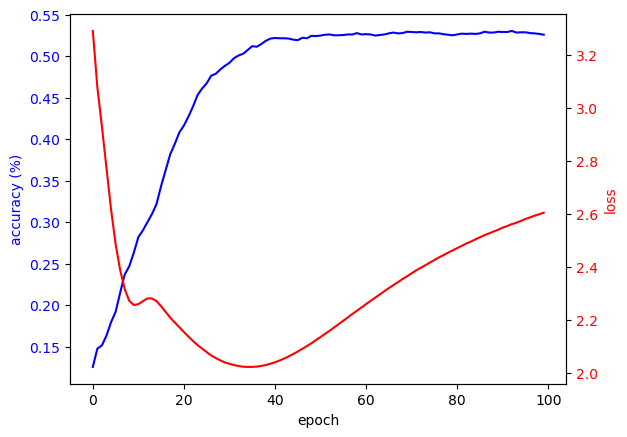

In [76]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.plot(range(len(accuracies)), accuracies, color='blue')
ax1.set_ylabel('accuracy (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, color='red')
ax2.set_ylabel('loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

In [58]:
accuracies_2 = []
losses_2 = []
model = NeuralNetwork(size=2048)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for e in range(100):
    print(f"Epoch {e+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    c, l = test(val_dataloader, model, loss_fn)
    accuracies_2.append(c)
    losses_2.append(l)


Epoch 1
-------------------------------
loss: 3.435747  [   64/19873]
loss: 3.436984  [ 6464/19873]
loss: 3.423784  [12864/19873]
loss: 3.430506  [19264/19873]
Test Error: 
 Accuracy: 6.1%, Avg loss: 3.424442 

Epoch 2
-------------------------------
loss: 3.424414  [   64/19873]
loss: 3.429589  [ 6464/19873]
loss: 3.406697  [12864/19873]
loss: 3.423506  [19264/19873]
Test Error: 
 Accuracy: 6.4%, Avg loss: 3.417385 

Epoch 3
-------------------------------
loss: 3.411875  [   64/19873]
loss: 3.422109  [ 6464/19873]
loss: 3.386972  [12864/19873]
loss: 3.416448  [19264/19873]
Test Error: 
 Accuracy: 8.0%, Avg loss: 3.409485 

Epoch 4
-------------------------------
loss: 3.397501  [   64/19873]
loss: 3.414029  [ 6464/19873]
loss: 3.363566  [12864/19873]
loss: 3.408613  [19264/19873]
Test Error: 
 Accuracy: 8.8%, Avg loss: 3.400243 

Epoch 5
-------------------------------
loss: 3.380370  [   64/19873]
loss: 3.405009  [ 6464/19873]
loss: 3.334330  [12864/19873]
loss: 3.399773  [19264/198

In [108]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for e in range(10):
    print(f"Epoch {e+1}\n-------------------------------")
    train_fxn(train_dataloader, model, loss_fn, optimizer)
    c, l = test(val_dataloader, model, loss_fn)
    accuracies_2.append(c)
    losses_2.append(l)


Epoch 1
-------------------------------
loss: 0.916873  [   64/19873]
loss: 0.789562  [ 6464/19873]
loss: 0.876064  [12864/19873]
loss: 1.222396  [19264/19873]
Test Error: 
 Accuracy: 45.1%, Avg loss: 1.896070 

Epoch 2
-------------------------------
loss: 0.911897  [   64/19873]
loss: 0.784264  [ 6464/19873]
loss: 0.871240  [12864/19873]
loss: 1.214360  [19264/19873]
Test Error: 
 Accuracy: 45.3%, Avg loss: 1.895721 

Epoch 3
-------------------------------
loss: 0.906975  [   64/19873]
loss: 0.778981  [ 6464/19873]
loss: 0.866459  [12864/19873]
loss: 1.206344  [19264/19873]
Test Error: 
 Accuracy: 45.4%, Avg loss: 1.895393 

Epoch 4
-------------------------------
loss: 0.902072  [   64/19873]
loss: 0.773779  [ 6464/19873]
loss: 0.861685  [12864/19873]
loss: 1.198368  [19264/19873]
Test Error: 
 Accuracy: 45.3%, Avg loss: 1.895070 

Epoch 5
-------------------------------
loss: 0.897187  [   64/19873]
loss: 0.768602  [ 6464/19873]
loss: 0.856921  [12864/19873]
loss: 1.190386  [19264

In [112]:
torch.save(model.state_dict(), "model.pth")

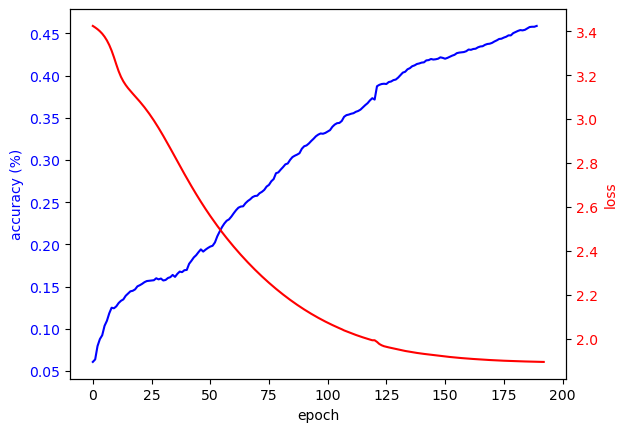

In [109]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.plot(range(len(accuracies_2)), accuracies_2, color='blue')
ax1.set_ylabel('accuracy (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(len(losses_2)), losses_2, color='red')
ax2.set_ylabel('loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')


In [62]:
class NeuralNetwork(nn.Module):
    def __init__(self, size=256):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(71636, size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

accuracies_3 = []
losses_3 = []
model_3 = NeuralNetwork(size=2048)
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.001)
for e in range(100):
    print(f"Epoch {e+1}\n-------------------------------")
    train_fxn(train_dataloader, model_3, loss_fn, optimizer)
    c, l = test(val_dataloader, model_3, loss_fn)
    accuracies_3.append(c)
    losses_3.append(l)


Epoch 1
-------------------------------
loss: 3.435303  [   64/19873]
loss: 3.433383  [ 6464/19873]
loss: 3.425956  [12864/19873]
loss: 3.436632  [19264/19873]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.429720 

Epoch 2
-------------------------------
loss: 3.421176  [   64/19873]
loss: 3.429466  [ 6464/19873]
loss: 3.411180  [12864/19873]
loss: 3.428868  [19264/19873]
Test Error: 
 Accuracy: 2.5%, Avg loss: 3.422830 

Epoch 3
-------------------------------
loss: 3.406147  [   64/19873]
loss: 3.419096  [ 6464/19873]
loss: 3.394997  [12864/19873]
loss: 3.422561  [19264/19873]
Test Error: 
 Accuracy: 2.6%, Avg loss: 3.415558 

Epoch 4
-------------------------------
loss: 3.395527  [   64/19873]
loss: 3.410601  [ 6464/19873]
loss: 3.370490  [12864/19873]
loss: 3.415933  [19264/19873]
Test Error: 
 Accuracy: 2.9%, Avg loss: 3.407149 

Epoch 5
-------------------------------
loss: 3.380742  [   64/19873]
loss: 3.402539  [ 6464/19873]
loss: 3.353793  [12864/19873]
loss: 3.408164  [19264/198

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(71636, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

accuracies_4 = []
losses_4 = []
model_4 = NeuralNetwork(size=2048)
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
for e in range(100):
    print(f"Epoch {e+1}\n-------------------------------")
    train_fxn(train_dataloader, model_4, loss_fn, optimizer)
    c, l = test(val_dataloader, model_4, loss_fn)
    accuracies_4.append(c)
    losses_4.append(l)

In [110]:
tfidf = TfidfVectorizer(max_features=200000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train['snip'])
X_val_tfidf = tfidf.transform(val['snip'])

x_train = [X_train_tfidf, x_train_cv]
x_val = [X_val_tfidf, x_val_cv]
# Combine TF-IDF and CountVectorizer features
from scipy.sparse import hstack
x_train_combined = hstack(x_train)
x_val_combined = hstack(x_val)

training_data = torch.tensor(x_train_combined.toarray(), dtype=torch.float32)
val_data = torch.tensor(x_val_combined.toarray(), dtype=torch.float32)
train_tensor = torch.utils.data.TensorDataset(training_data, training_labels)
val_tensor = torch.utils.data.TensorDataset(val_data, val_labels)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_tensor, batch_size=batch_size)
val_dataloader = DataLoader(val_tensor, batch_size=batch_size)

for X, y in val_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 266636])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(266636, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 31),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model_new_param = NeuralNetwork(size=2048)
optimizer = torch.optim.SGD(model_new_param.parameters(), lr=0.01)
accuracies_new_param = []
losses_new_param = []
for e in range(100):
    print(f"Epoch {e+1}\n-------------------------------")
    train_fxn(train_dataloader, model_new_param, loss_fn, optimizer)
    c, l = test(val_dataloader, model_new_param, loss_fn)
    accuracies_new_param.append(c)
    losses_new_param.append(l)


Epoch 1
-------------------------------
loss: 3.433814  [   64/19873]
loss: 3.403761  [ 6464/19873]
loss: 3.288266  [12864/19873]
loss: 3.335662  [19264/19873]
Test Error: 
 Accuracy: 10.1%, Avg loss: 3.287629 

Epoch 2
-------------------------------
loss: 3.203996  [   64/19873]
loss: 3.273270  [ 6464/19873]
